In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
titanic = pd.read_csv('./Titanic.csv')

# Display the first few rows of the dataframe
titanic.head()

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,2,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,3,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,4,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,5,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


# Step 1

In [2]:
def QuantileBinning(feature, bin_number):
    """
    This function takes a numerical feature and the number of bins, and
    returns the feature binned into quantile-based bins.

    Parameters:
    - feature (pandas.Series): The numerical feature to be binned.
    - bin_number (int): The number of quantile bins.

    Returns:
    - pandas.Series: A series of discrete features binned by quantile.
    """
    # Use qcut to create quantile-based bins for the feature
    # If there are fewer unique values than bins, qcut could throw an error.
    # 'duplicates' parameter handles this by dropping redundant bins.
    return pd.qcut(feature, q=bin_number, labels=False, duplicates='drop')

# One example
feature_test = pd.DataFrame(np.random.rand(100),  columns=['Column_A'])
feature_test_discrete = QuantileBinning(feature_test['Column_A'], 10)


def label_encoder(feature):
    unique_labels = pd.unique(feature)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    transformed_feature = np.array([label_to_int[label] for label in feature])
    return transformed_feature

In [3]:
from sklearn.model_selection import train_test_split

# Fill missing values in 'age' with the average age
titanic['age'].fillna(titanic['age'].mean(), inplace=True)

# Discretization
features = ['pclass', 'sex', 'age', 'sibsp']
target = 'survived'
titanic = titanic[features + [target]]
titanic['pclass'] = titanic['pclass'].map({'1st': 1, '2nd': 2, '3rd': 3})
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})



# Split the data into 80% training and 20% test sets
X = titanic[features]
y = titanic[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train['age'] = QuantileBinning(X_train['age'], 10)
X_test['age'] = QuantileBinning(X_test['age'], 10)


In [4]:
X_train.head()

,pclass,sex,age,sibsp
772,3,0,1,0
543,2,0,6,0
289,1,1,1,0
10,1,0,7,1
147,1,0,4,0


# Step 2

In [5]:
# define your entropy function and information gain function
def entropy(feature):
    counts = np.bincount(feature)
    probabilities = counts / len(feature)
    return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

# Calculate Information Gain for each feature in the training set

def information_gain(data, split_feature, target):
    total_entropy = entropy(data[target])
    values, counts = np.unique(data[split_feature], return_counts=True)
    weighted_entropy = np.sum([(counts[i] / np.sum(counts)) * entropy(data.where(data[split_feature] == values[i]).dropna()[target]) for i in range(len(values))])
    return total_entropy - weighted_entropy

info_gains = {feature: information_gain(X_train.join(y_train), feature, target) for feature in features}


In [6]:
info_gains

{'pclass': 0.06353574221838065,
 'sex': 0.20968297666244173,
 'age': 0.020855770628040227,
 'sibsp': 0.02531230300308862}

So the first split should be "sex"

# Step 3

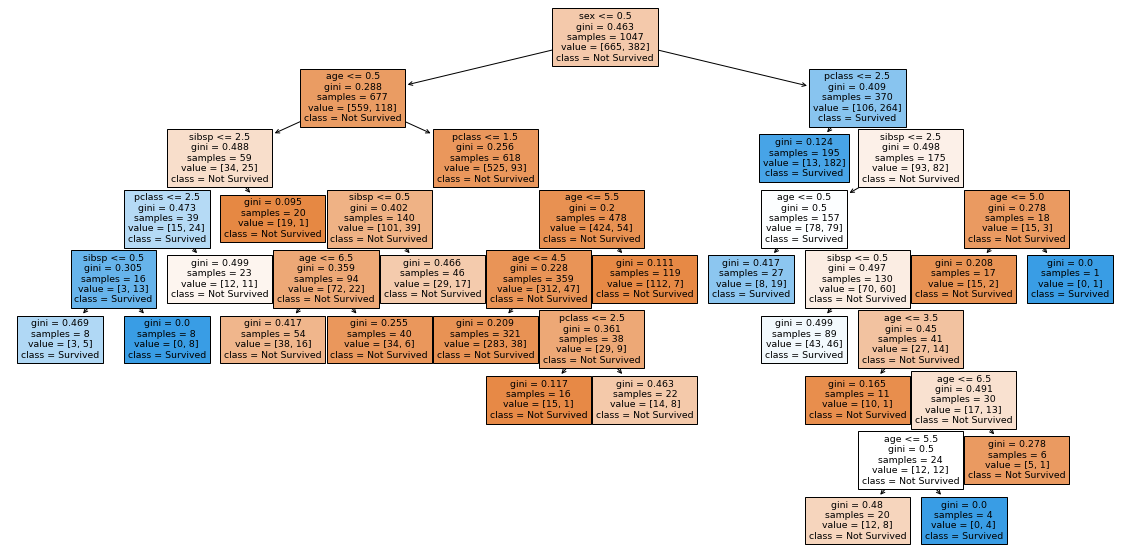

In [7]:
from sklearn.tree import DecisionTreeClassifier, plot_tree #sklearn.metrics is not imported !!!

# Instantiate the DecisionTreeClassifier
clf = DecisionTreeClassifier(max_leaf_nodes=20, random_state=10462028)

# Prepare the features and target variables for training

# Fit the decision tree model
clf.fit(X_train, y_train)

# Plot the full decision tree

plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=features, class_names=['Not Survived', 'Survived'])
plt.show()

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define your performance metrics including accuracy, precision, recall and F1-scorre
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

initial_metrics = evaluate_model(clf, X_test, y_test)
print(initial_metrics)

{'Accuracy': 0.732824427480916, 'Precision': 0.7608695652173914, 'Recall': 0.5932203389830508, 'F1 Score': 0.6666666666666667}


# Step 4

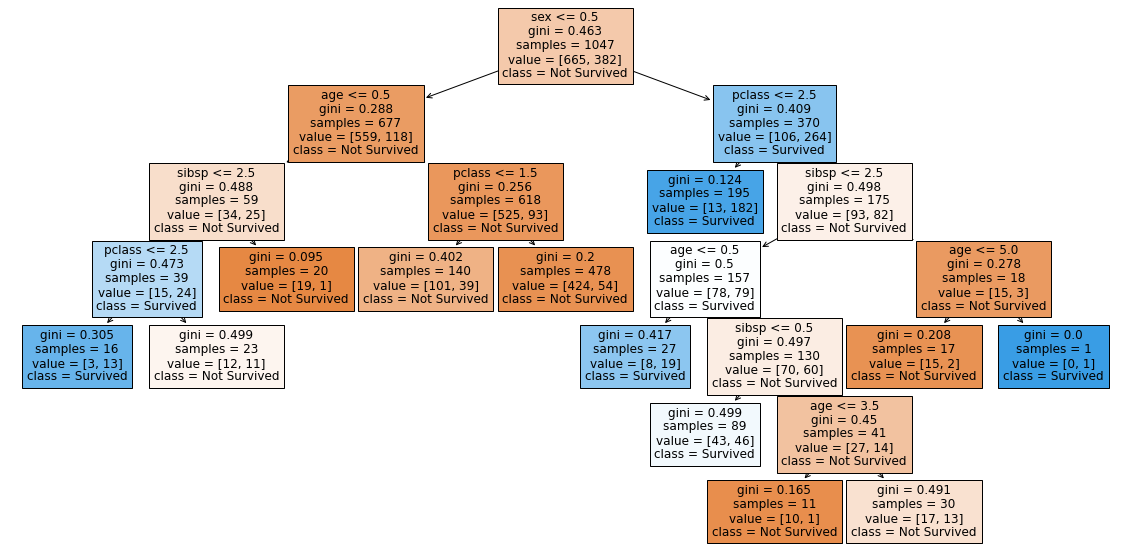

In [9]:
from sklearn.model_selection import GridSearchCV

# Define a range of max_leaf_nodes values to search
param_grid = {'max_leaf_nodes': list(range(5, 20))}

# Run grid search with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=10462028), param_grid, cv=5)
grid_search.fit(X_train, y_train) # Note testing set cannot be used

# Get the best estimator with the optimal max_leaf_nodes parameter
best_tree = grid_search.best_estimator_


# Plot the pruned decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_tree, filled=True, feature_names=features, class_names=['Not Survived', 'Survived'])
plt.show()


# Step 5


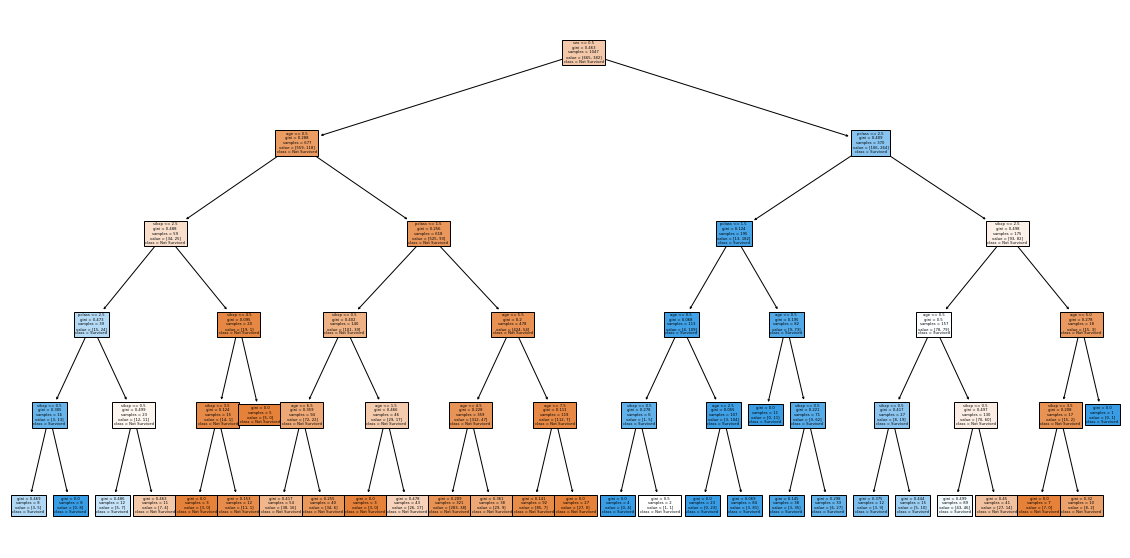

In [10]:
## it's an example (max_depth)
dt_max_depth = DecisionTreeClassifier(max_depth=5, random_state=10462028)
dt_max_depth.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dt_max_depth, filled=True, feature_names=features, class_names=['Not Survived', 'Survived'])
plt.show()

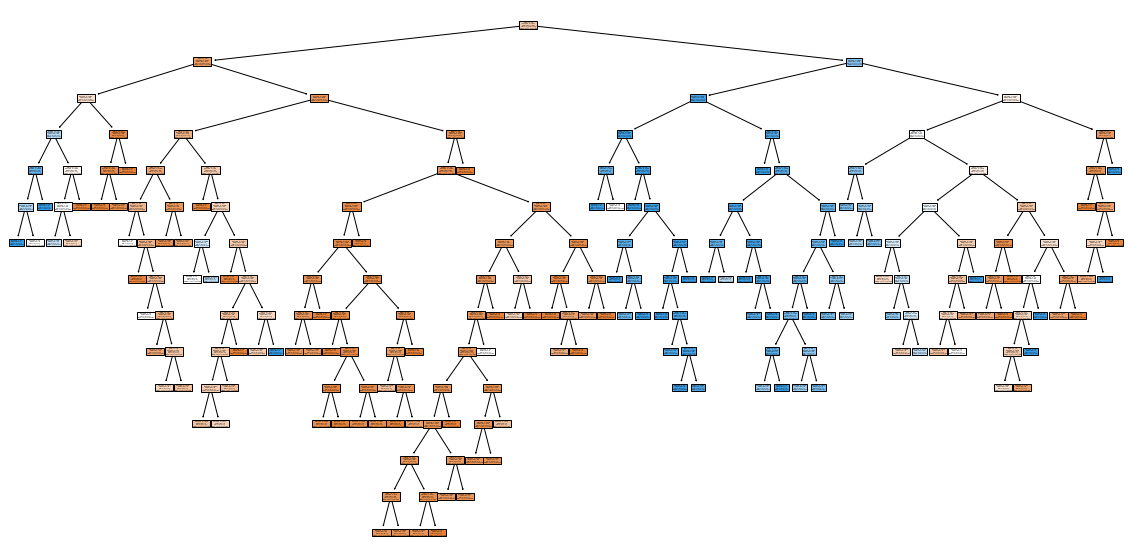

In [11]:
dt_opt_critia = DecisionTreeClassifier(criterion='entropy', random_state=10462028)
dt_opt_critia.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dt_opt_critia, filled=True, feature_names=features, class_names=['Not Survived', 'Survived'])
plt.show()

In [12]:
def ensemble_vote(models, X):

    # Perform majority vote
    # For each sample, count the votes for each class (0 or 1)

    # Determine the winning class for each sample: it's the one with the most votes
    # If there's a tie, we choose the class with the highest index (1 in this case)
    predictions = np.array([model.predict(X) for model in models])
    ensemble_predictions = np.apply_along_axis(lambda x: np.bincount(x, minlength=2).argmax(), axis=0, arr=predictions)

    return ensemble_predictions

# Use the defined function to get predictions from the ensemble of the three trees
models = [best_tree, dt_max_depth, dt_opt_critia]
ensemble_predictions = ensemble_vote(models, X_test)

# Calculate performance metrics for the ensemble using the previously defined function
ensemble_metrics = {
    'Accuracy': accuracy_score(y_test, ensemble_predictions),
    'Precision': precision_score(y_test, ensemble_predictions),
    'Recall': recall_score(y_test, ensemble_predictions),
    'F1 Score': f1_score(y_test, ensemble_predictions)
}
print(ensemble_metrics)


{'Accuracy': 0.7175572519083969, 'Precision': 0.7391304347826086, 'Recall': 0.576271186440678, 'F1 Score': 0.6476190476190476}


In [13]:
from sklearn.ensemble import RandomForestClassifier

# Train a random forest model using the optimal tree you found in step 4 and compare the ensembled model with the random forest
rf = RandomForestClassifier(n_estimators=50, max_leaf_nodes=best_tree.get_params()['max_leaf_nodes'], random_state=10462028)
rf.fit(X_train, y_train)

rf_metrics = evaluate_model(rf, X_test, y_test)
print(rf_metrics)

{'Accuracy': 0.7366412213740458, 'Precision': 0.7752808988764045, 'Recall': 0.5847457627118644, 'F1 Score': 0.6666666666666666}
